## Ad Click Prediction Model

In [226]:
# Import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import seaborn as sns
import re

In [231]:
# Import ML libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold

In [183]:
# Import the data files
dfClicks = pd.read_csv(r"./02 Data/ClickTraining.csv", encoding = 'utf-8')
print()

### 1. Exploratory Data Analysis

In [184]:
dfClicks.head(3)

,Unnamed: 0,Region,Daytime,Carrier,Time_On_Previous_Website,Weekday,Social_Network,Number_of_Previous_Orders,Clicks_Conversion,Restaurant_Type
0,18847,Alsace and East France,0.223254,SFR,8.066935,Saturday,Instagram,3,1,French
1,18895,West France,0.734393,Bouygues,257.567079,Saturday,Twitter,3,1,French
2,2986,Paris,0.781317,SFR,1427.640826,Wednesday,Instagram,6,1,French


In [185]:
dfClicks.describe()

,Unnamed: 0,Daytime,Time_On_Previous_Website,Number_of_Previous_Orders,Clicks_Conversion
count,18000.000000,18000.000000,18000.000000,18000.00000,18000.000000
mean,9982.116000,0.495189,902.603316,3.08200,0.844556
std,5776.488376,0.288272,519.690977,1.90812,0.362338
min,1.000000,0.000121,5.032679,0.00000,0.000000
25%,4978.250000,0.244788,454.132414,2.00000,1.000000
50%,9963.500000,0.492348,902.859783,3.00000,1.000000
75%,14994.250000,0.740757,1352.777426,4.00000,1.000000
max,20000.000000,0.999992,1799.874529,11.00000,1.000000


In [186]:
categorical_vars = ['Region', 'Carrier',	'Weekday',	'Social_Network','Restaurant_Type']
numerical_vars = [	'Time_On_Previous_Website',	'Number_of_Previous_Orders', 'Daytime']

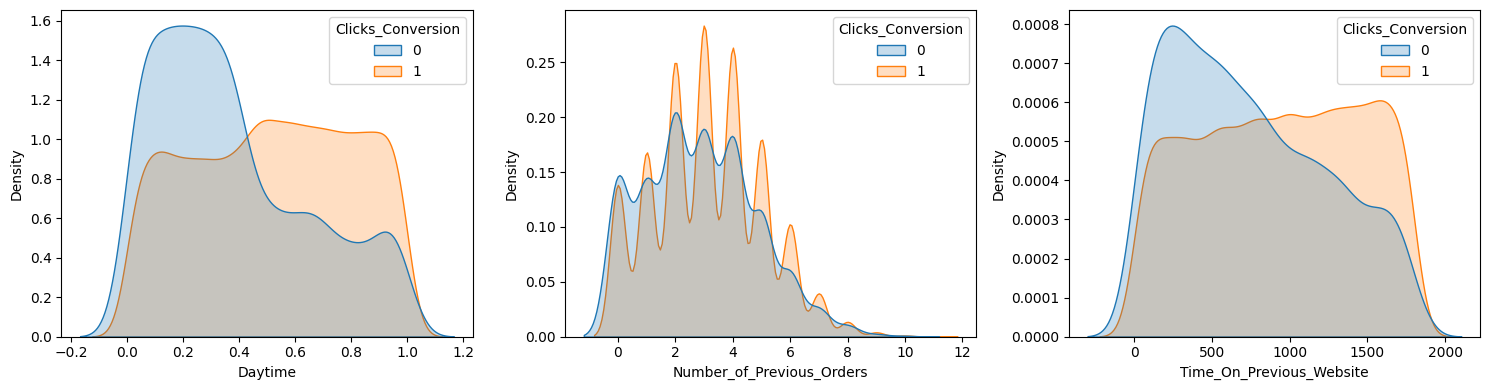

In [187]:
# Density Plots for continuous variables
fig, axis = plt.subplots(1, 3, figsize = (3 * 5, 4))
sns.kdeplot(data = dfClicks, x = dfClicks['Daytime'], hue = 'Clicks_Conversion', fill = True, common_norm= False, ax = axis[0])
sns.kdeplot(data = dfClicks, x = dfClicks['Number_of_Previous_Orders'], hue = 'Clicks_Conversion', fill = True, common_norm= False, ax = axis[1] )
sns.kdeplot(data = dfClicks, x = dfClicks['Time_On_Previous_Website'], hue = 'Clicks_Conversion', fill = True, common_norm= False, ax = axis[2])
plt.tight_layout()
plt.show()

C:\Users\elric\AppData\Local\Temp\ipykernel_36176\2165102131.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis[0].set_xticklabels(axis[0].get_xticklabels(), rotation=20, ha='right')
C:\Users\elric\AppData\Local\Temp\ipykernel_36176\2165102131.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis[1].set_xticklabels(axis[1].get_xticklabels(), rotation=20, ha='right')
C:\Users\elric\AppData\Local\Temp\ipykernel_36176\2165102131.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis[2].set_xticklabels(axis[2].get_xticklabels(), rotation=20, ha='right')
C:\Users\elric\AppData\Local\Temp\ipykernel_36176\2165102131.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using 

[Text(0, 0, 'French'),
 Text(1, 0, 'Burger'),
 Text(2, 0, 'Groceries'),
 Text(3, 0, 'Kebab'),
 Text(4, 0, 'Sushi')]

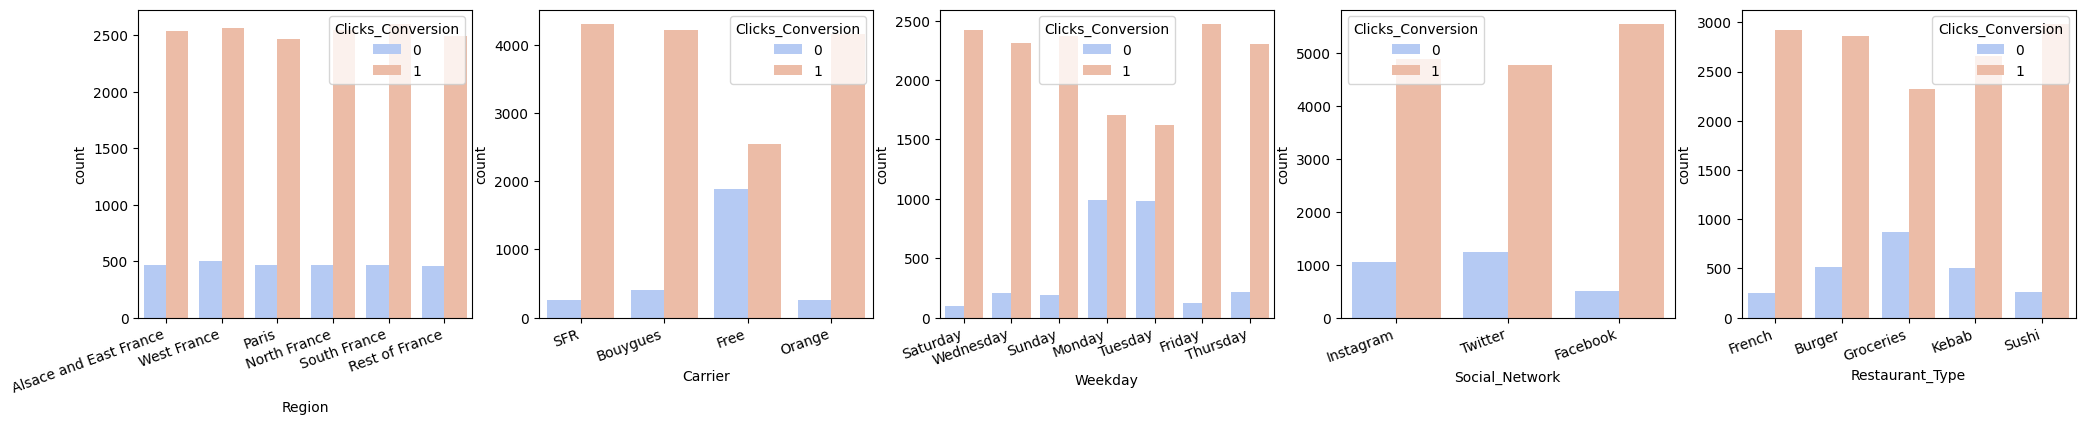

In [188]:
# Click/No Click split for categorical variables
fig, axis = plt.subplots(1, 5, figsize = (5 * 5, 4))
sns.countplot(data=dfClicks, x= dfClicks['Region'], hue='Clicks_Conversion', palette= 'coolwarm', ax = axis[0])
axis[0].set_xticklabels(axis[0].get_xticklabels(), rotation=20, ha='right')

sns.countplot(data=dfClicks, x= dfClicks['Carrier'], hue='Clicks_Conversion', palette= 'coolwarm', ax = axis[1])
axis[1].set_xticklabels(axis[1].get_xticklabels(), rotation=20, ha='right')

sns.countplot(data=dfClicks, x= dfClicks['Weekday'], hue='Clicks_Conversion', palette= 'coolwarm', ax = axis[2])
axis[2].set_xticklabels(axis[2].get_xticklabels(), rotation=20, ha='right')

sns.countplot(data=dfClicks, x= dfClicks['Social_Network'], hue='Clicks_Conversion', palette= 'coolwarm', ax = axis[3])
axis[3].set_xticklabels(axis[3].get_xticklabels(), rotation=20, ha='right')

sns.countplot(data=dfClicks, x= dfClicks['Restaurant_Type'], hue='Clicks_Conversion', palette= 'coolwarm', ax = axis[4])
axis[4].set_xticklabels(axis[4].get_xticklabels(), rotation=20, ha='right')

### 2a. Data Cleaning and Pre-Processing

In [189]:
# Check missing values
print(dfClicks.isna().sum())

Unnamed: 0                      0
Region                          0
Daytime                         0
Carrier                         0
Time_On_Previous_Website        0
Weekday                         0
Social_Network                  0
Number_of_Previous_Orders       0
Clicks_Conversion               0
Restaurant_Type              1848
dtype: int64


In [190]:
# Train - categorical
print(dfClicks['Restaurant_Type'].unique(), "\n",
      dfClicks['Social_Network'].unique(),"\n",
      dfClicks['Weekday'].unique(),"\n",
      dfClicks['Carrier'].unique(),"\n",
      dfClicks['Region'].unique()
)

['French' 'Burger' 'Groceries' 'Kebab' 'Sushi' nan] 
 ['Instagram' 'Twitter' 'Facebook'] 
 ['Saturday' 'Wednesday' 'Sunday' 'Monday' 'Tuesday' 'Friday' 'Thursday'] 
 ['SFR' 'Bouygues' 'Free' 'Orange'] 
 ['Alsace and East France' 'West France' 'Paris' 'North France'
 'South France' 'Rest of France']


In [191]:
# Check data types
print(dfClicks.dtypes)

Unnamed: 0                     int64
Region                        object
Daytime                      float64
Carrier                       object
Time_On_Previous_Website     float64
Weekday                       object
Social_Network                object
Number_of_Previous_Orders      int64
Clicks_Conversion              int64
Restaurant_Type               object
dtype: object


In [192]:
# Handling restaurant types labelled as "nan"
dfClicks['Restaurant_Type'] = dfClicks['Restaurant_Type'].replace(["nan", np.nan], "Unknown")
dfClicks.Restaurant_Type.unique()

array(['French', 'Burger', 'Groceries', 'Kebab', 'Sushi', 'Unknown'],
      dtype=object)

In [193]:
# One-Hot Encoding for Categorical Variables
dfClicks_encoded = pd.get_dummies(dfClicks, columns= categorical_vars, drop_first= True, dtype= int)
dfClicks_encoded.head(3)

,Unnamed: 0,Daytime,Time_On_Previous_Website,Number_of_Previous_Orders,Clicks_Conversion,Region_North France,Region_Paris,Region_Rest of France,Region_South France,Region_West France,...,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Social_Network_Instagram,Social_Network_Twitter,Restaurant_Type_French,Restaurant_Type_Groceries,Restaurant_Type_Kebab,Restaurant_Type_Sushi,Restaurant_Type_Unknown
0,18847,0.223254,8.066935,3,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
1,18895,0.734393,257.567079,3,1,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0
2,2986,0.781317,1427.640826,6,1,0,1,0,0,0,...,0,0,1,1,0,1,0,0,0,0


In [194]:
dfClicks_encoded.columns

Index(['Unnamed: 0', 'Daytime', 'Time_On_Previous_Website',
       'Number_of_Previous_Orders', 'Clicks_Conversion', 'Region_North France',
       'Region_Paris', 'Region_Rest of France', 'Region_South France',
       'Region_West France', 'Carrier_Free', 'Carrier_Orange', 'Carrier_SFR',
       'Weekday_Monday', 'Weekday_Saturday', 'Weekday_Sunday',
       'Weekday_Thursday', 'Weekday_Tuesday', 'Weekday_Wednesday',
       'Social_Network_Instagram', 'Social_Network_Twitter',
       'Restaurant_Type_French', 'Restaurant_Type_Groceries',
       'Restaurant_Type_Kebab', 'Restaurant_Type_Sushi',
       'Restaurant_Type_Unknown'],
      dtype='object')

In [195]:
# Checking for class imbalance
print(dfClicks['Clicks_Conversion'].value_counts())

Clicks_Conversion
1    15202
0     2798
Name: count, dtype: int64


In [196]:
# Function to apply SMOTE to balance out the minority class (to use in Logistic Regression)
def applySMOTE(data, sampling_strategy = 0.5):
    Train_X = data.drop(columns=['Clicks_Conversion'])
    Train_Y = data['Clicks_Conversion']
    smote = SMOTE(sampling_strategy= sampling_strategy)
    data_X_smote, data_Y_smote = smote.fit_resample(Train_X, Train_Y)

    data_resampled = pd.concat([pd.DataFrame(data_X_smote, columns=data_X_smote.columns), 
                                pd.DataFrame(data_Y_smote, columns=['Clicks_Conversion'])], axis=1)
    return data_resampled

In [197]:
# Class distribution after SMOTE
dfClicks_resampled = applySMOTE(dfClicks_encoded, 0.6)
dfClicks_resampled['Clicks_Conversion'].value_counts()

Clicks_Conversion
1    15202
0     9121
Name: count, dtype: int64

### 2b. Correlation Analysis & Feature Engineering

In [198]:
dfClicks_encoded.columns

Index(['Unnamed: 0', 'Daytime', 'Time_On_Previous_Website',
       'Number_of_Previous_Orders', 'Clicks_Conversion', 'Region_North France',
       'Region_Paris', 'Region_Rest of France', 'Region_South France',
       'Region_West France', 'Carrier_Free', 'Carrier_Orange', 'Carrier_SFR',
       'Weekday_Monday', 'Weekday_Saturday', 'Weekday_Sunday',
       'Weekday_Thursday', 'Weekday_Tuesday', 'Weekday_Wednesday',
       'Social_Network_Instagram', 'Social_Network_Twitter',
       'Restaurant_Type_French', 'Restaurant_Type_Groceries',
       'Restaurant_Type_Kebab', 'Restaurant_Type_Sushi',
       'Restaurant_Type_Unknown'],
      dtype='object')

In [199]:
def plotCorrelation(data):
    '''
    data : A correlation matrix generated with .corr()
    '''
    # Plot heatmap
    fig, ax = plt.subplots(figsize = (5,4))
    cax = ax.imshow(data, cmap = "coolwarm", interpolation="nearest")
    fig.colorbar(cax)

    # Set axis labels
    ax.set_xticks(np.arange(len(data.columns)))
    ax.set_yticks(np.arange(len(data.columns)))
    ax.set_xticklabels(data.columns, rotation = 30, fontsize = 5)
    ax.set_yticklabels(data.columns, rotation = 30, fontsize = 5)

    # Put correlation values
    for i in range(len(data.columns)):
        for j in range(len(data.columns)):
            ax.text(j, i, f"{data.iloc[i,j]:.2f}", ha = 'center', va = 'center', color = 'black', fontsize = 8)
    plt.show()

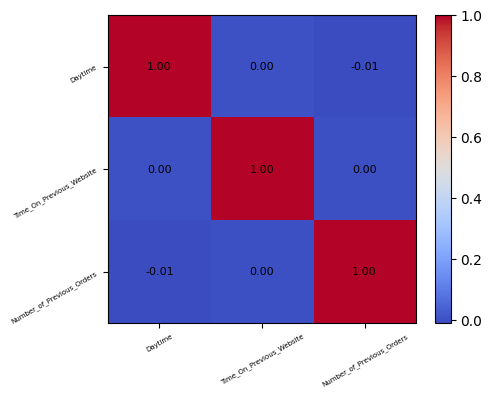

In [200]:
# Correlation Heatmap for continuous variables
correlation_dfClicks = dfClicks_encoded[['Daytime', 'Time_On_Previous_Website', 'Number_of_Previous_Orders']].corr()
plotCorrelation(correlation_dfClicks)


In [201]:
# Feature engineering
def ClickPrediction_FeatureEng(data):
    
    # Polynomial features - captures non-linear relationships
    data['Daytime_^2'] = data['Daytime']**2
    data['PreviousOrders_^2'] = data['Number_of_Previous_Orders']**2

    # Interaction terms - combined effect between two variables
    data['DaytimeXOrders'] = data['Daytime'] * data['Number_of_Previous_Orders']
    
    # Recency Transformation (Inverse Time)
    data['InvTimeonPrevSite'] = 1/ (1 + data['Time_On_Previous_Website'])

     # Weekend Indicator (Binary)
    data['Is_Weekend'] = ((data['Weekday_Saturday'] == 1) | 
                           (data['Weekday_Sunday'] == 1)).astype(int)
    
    # Ratio Features (Relative Importance)
    data['Orders_Per_Daytime'] = data['Number_of_Previous_Orders'] / (data['Daytime'] + 1)

    return data

In [202]:
# Correlation matrix after feature engineering
dfClicks_encoded_engineered = ClickPrediction_FeatureEng(dfClicks_encoded)

correlation2_dfClicks = dfClicks_encoded_engineered[['Daytime', 'Time_On_Previous_Website', 'Number_of_Previous_Orders',
                                        'Daytime_^2', 'PreviousOrders_^2','DaytimeXOrders','InvTimeonPrevSite',
                                         'Is_Weekend', 'Orders_Per_Daytime' ]].corr()

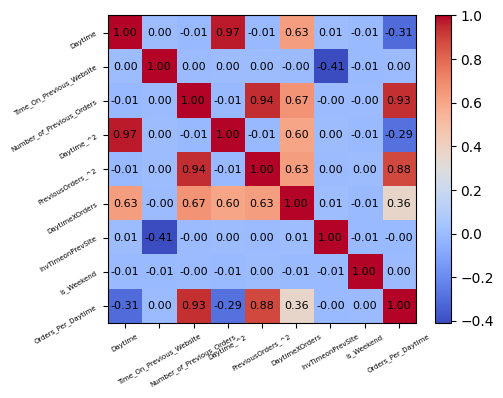

In [203]:
plotCorrelation(correlation2_dfClicks)

Decisions:
* Drop both polynomial features (Daytime^2, PreviousOrders^2)
* Drop one between 'Orders per Daytime' (I have decided to a similar original feature: 'Numer_of_Previous_Orders')
* Keep DaytimeXOrders (Correlation coefficients are not too high - also contributes to Top10 features, see below)
* Keep InvTimeonPrevSite (contributes to Top10 negative features, see below)

In [204]:
# Function to plot features in order of correlation

def plot_top_bottom_target_correlations(data):
    
    # Calculate correlation with the target variable (Clicks_Conversion)
    cor_with_target = data.corr()["Clicks_Conversion"].dropna() 
    
    # Exclude the target itself (Clicks_Conversion)
    cor_with_target = cor_with_target[cor_with_target.index != "Clicks_Conversion"]
    
    # Convert to DataFrame, sort and select top 10 positive/bottom 10 negative correlations
    cor_with_target = cor_with_target.reset_index()
    cor_with_target.columns = ['Variable', 'Correlation']
    top_10 = cor_with_target.sort_values(by='Correlation', ascending=False).head(10)
    bottom_10 = cor_with_target.sort_values(by='Correlation', ascending=True).head(10)
    
    # Combine top and bottom into one DataFrame
    top_and_bottom = pd.concat([top_10, bottom_10])
    top_and_bottom['Type'] = top_and_bottom['Correlation'].apply(
        lambda x: "Top 10 Positive" if x > 0 else "Bottom 10 Negative"
    )
    
    # Plot the correlations
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_and_bottom, y='Variable', x='Correlation', hue='Type', palette=["blue", "red"])
    
    plt.xlabel('Correlation with Target')
    plt.ylabel('Feature')
    plt.axvline(x=0, color='black',linewidth=1, linestyle='--')  # Line at zero for reference
    plt.legend(title="Correlation Type")
    plt.tight_layout()
    plt.show()

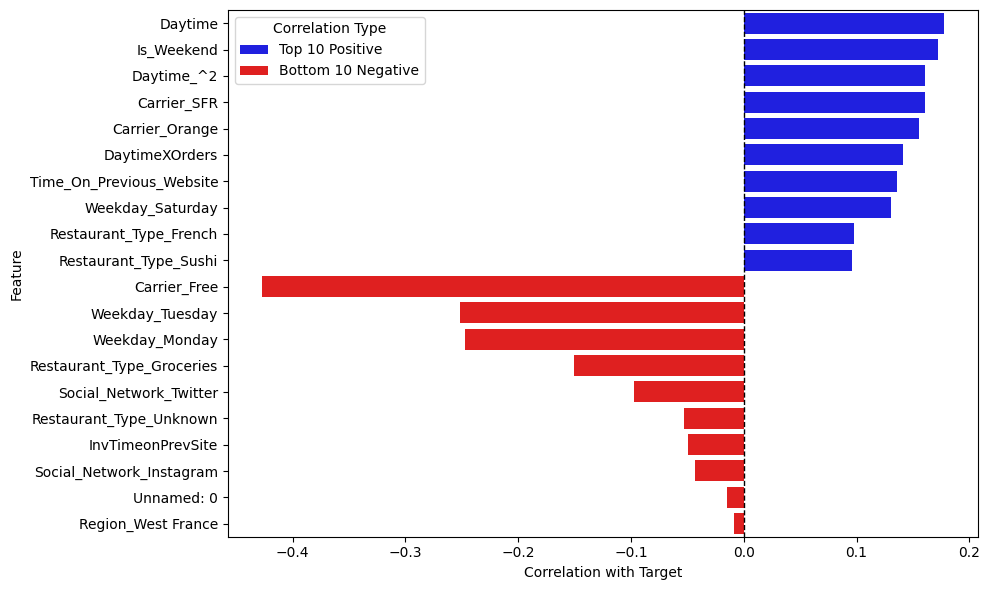

In [205]:
plot_top_bottom_target_correlations(dfClicks_encoded_engineered)

In [206]:
# Drop columns highly correlated with each other
columns_to_drop = ['Daytime_^2', 'PreviousOrders_^2', 'Orders_Per_Daytime' ]
dfClicks_encoded_engineered_v2 = dfClicks_encoded_engineered.drop(columns= columns_to_drop, axis = 1)

In [207]:
dfClicks_encoded_engineered_v2.head()

,Unnamed: 0,Daytime,Time_On_Previous_Website,Number_of_Previous_Orders,Clicks_Conversion,Region_North France,Region_Paris,Region_Rest of France,Region_South France,Region_West France,...,Social_Network_Instagram,Social_Network_Twitter,Restaurant_Type_French,Restaurant_Type_Groceries,Restaurant_Type_Kebab,Restaurant_Type_Sushi,Restaurant_Type_Unknown,DaytimeXOrders,InvTimeonPrevSite,Is_Weekend
0,18847,0.223254,8.066935,3,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0.669762,0.110291,1
1,18895,0.734393,257.567079,3,1,0,0,0,0,1,...,0,1,1,0,0,0,0,2.203180,0.003867,1
2,2986,0.781317,1427.640826,6,1,0,1,0,0,0,...,1,0,1,0,0,0,0,4.687902,0.000700,0
3,1842,0.310846,1606.262115,4,1,0,1,0,0,0,...,1,0,0,0,0,0,0,1.243385,0.000622,0
4,3371,0.910376,480.234887,2,1,1,0,0,0,0,...,0,0,0,1,0,0,0,1.820752,0.002078,1


In [208]:
dfClicks_encoded_engineered_v2.columns

Index(['Unnamed: 0', 'Daytime', 'Time_On_Previous_Website',
       'Number_of_Previous_Orders', 'Clicks_Conversion', 'Region_North France',
       'Region_Paris', 'Region_Rest of France', 'Region_South France',
       'Region_West France', 'Carrier_Free', 'Carrier_Orange', 'Carrier_SFR',
       'Weekday_Monday', 'Weekday_Saturday', 'Weekday_Sunday',
       'Weekday_Thursday', 'Weekday_Tuesday', 'Weekday_Wednesday',
       'Social_Network_Instagram', 'Social_Network_Twitter',
       'Restaurant_Type_French', 'Restaurant_Type_Groceries',
       'Restaurant_Type_Kebab', 'Restaurant_Type_Sushi',
       'Restaurant_Type_Unknown', 'DaytimeXOrders', 'InvTimeonPrevSite',
       'Is_Weekend'],
      dtype='object')

In [209]:
numerical_vars_v2 = ['Time_On_Previous_Website',	'Number_of_Previous_Orders', 'Daytime', 'DaytimeXOrders', 'InvTimeonPrevSite']

### Click Prediction Models

In [210]:
# Function to evaulate the models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print("Accuracy:", f"{accuracy_score(y_test, y_pred):.4f}")
    print("Precision:", f"{precision_score(y_test, y_pred):.4f}")
    print("Recall:", f"{recall_score(y_test, y_pred):.4f}")
    print("F1 Score:", f"{f1_score(y_test, y_pred):.4f}")
    print("ROC-AUC Score:", f"{roc_auc_score(y_test, y_prob):.4f}")

#### Model 1. Logistic Regression

In [211]:
from sklearn.linear_model import LogisticRegression

# Balance Classes using SMOTE
dfClicks_encoded_engineered_v2_resampled = applySMOTE(dfClicks_encoded_engineered_v2, 0.7)

# Split data into train and test
X = dfClicks_encoded_engineered_v2_resampled.drop(columns=['Clicks_Conversion'])
y = dfClicks_encoded_engineered_v2_resampled['Clicks_Conversion']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale continuous variables: Training Set
scaler_train = MinMaxScaler()
X_train[numerical_vars_v2] = scaler_train.fit_transform(X_train[numerical_vars_v2])

# Scale continuous variables: Test Set
scaler_test = MinMaxScaler()
X_test[numerical_vars_v2] = scaler_test.fit_transform(X_test[numerical_vars_v2])

In [212]:
# Fit a baseline model
model_LogReg = LogisticRegression()
model_LogReg.fit(X_train, y_train)

c:\Users\elric\Documents\01 DSBA\04 Term 1\06 Marketing Analytics\04 Python Implementation\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [213]:
# Evaulate the model
evaluate_model(model_LogReg, X_test, y_test)

Accuracy: 0.9068
Precision: 0.9199
Recall: 0.9217
F1 Score: 0.9208
ROC-AUC Score: 0.9702


#### Model 2: Random Forest

In [214]:
from sklearn.ensemble import RandomForestClassifier

# Balance Classes using SMOTE
dfClicks_encoded_engineered_v2_resampled = applySMOTE(dfClicks_encoded_engineered_v2, 0.5)

# Split data into train and test
X = dfClicks_encoded_engineered_v2_resampled.drop(columns=['Clicks_Conversion'])
y = dfClicks_encoded_engineered_v2_resampled['Clicks_Conversion']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [215]:
# Fit a baseline model
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

RandomForestClassifier()

In [216]:
# Evaulate the model
evaluate_model(model_rf, X_test, y_test)

Accuracy: 0.9226
Precision: 0.9322
Recall: 0.9533
F1 Score: 0.9426
ROC-AUC Score: 0.9773


In [219]:
# Hyperparamter tuning
param_grid = {
    'n_estimators' : [50, 100, 200],  # No of trees
    'max_depth' : [5, 10, 20], # Smaller trees might prevent overfitting
    'min_samples_split' : [2, 5, 10] # Higher min_samples prevents small node splits, might reduce overfitting
}

model_rf_2 = RandomForestClassifier()
grid_search = GridSearchCV(model_rf_2, param_grid, cv=5, scoring='f1', n_jobs= -1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

In [220]:
# Evaluate the tuned model
evaluate_model(best_rf, X_test, y_test)

Accuracy: 0.9226
Precision: 0.9319
Recall: 0.9536
F1 Score: 0.9426
ROC-AUC Score: 0.9779


#### Model 3. Gradient Boosting

In [228]:
from lightgbm import LGBMClassifier

# Remove special Characters from Column Names in the data (issue with LGBM)
dfClicks_encoded_engineered_v2_lgbm= dfClicks_encoded_engineered_v2.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# Balance Classes using SMOTE
dfClicks_encoded_engineered_v2_resampled = applySMOTE(dfClicks_encoded_engineered_v2_lgbm, 0.5)

# Split data into train and test
X = dfClicks_encoded_engineered_v2_resampled.drop(columns=['Clicks_Conversion'])
y = dfClicks_encoded_engineered_v2_resampled['Clicks_Conversion']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [242]:
# Fit a baseline model
model_lgbm = LGBMClassifier()
model_lgbm.fit(X_train, y_train)

LGBMClassifier()

In [246]:
# Evaluate the Model
evaluate_model(model_lgbm, X_test, y_test)

Accuracy: 0.9401
Precision: 0.9550
Recall: 0.9553
F1 Score: 0.9551
ROC-AUC Score: 0.9850


In [254]:
# Hyperparameter tuning with Bayesian Hyperparameter Optimization
import optuna

def objective_function(trial, X_train, y_train):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000), # No. of trees i.e. boosting rounds
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True), # Learning rate (slower might increase accuracy)
        "max_depth": trial.suggest_int("max_depth", 3, 15), # Big/Small trees
        "subsample": trial.suggest_float("subsample", 0.5, 1.0), # Fraction of training samples per tree (Lower is more random, might reduce overfitting)
        "lambda_l2": trial.suggest_float("lambda", 1e-3, 10, log=True), # L2 regularization
    }

    # Set up cross-validation (within the training set)
    stratKF = StratifiedKFold(n_splits= 5, shuffle= True, random_state= 42)

    f1_scores = [] # Store the f1 scores with each iteration, eventually we shall try to optimize the mean score
    
    for train_idx, val_idx in stratKF.split(X_train, y_train):
        
        X_train_CV, y_train_CV = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val_CV, y_val_CV = X_train.iloc[val_idx], y_train.iloc[val_idx]

        # Fit model, get predictions and compute the score
        model = LGBMClassifier(**params, random_state= 42)
        model.fit(X_train_CV, y_train_CV)

        y_prob = model.predict_proba(X_val_CV)[:,1]
        y_pred = (y_prob > 0.5).astype(int)
        f1 = f1_score(y_val_CV, y_pred)
        
        f1_scores.append(f1)
    
    return np.mean(f1_scores)

In [255]:
# Run Bayesian Optimization with Cross-Validation
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective_function(trial, X_train, y_train), n_trials= 10)

# Print best hyperparameters
print("Best Hyperparameters:", study.best_params)

[I 2025-02-06 00:25:34,338] A new study created in memory with name: no-name-66750d8f-0990-4d02-9e66-1fa0e4b7c698
[I 2025-02-06 00:25:38,237] Trial 0 finished with value: 0.9483513988806532 and parameters: {'n_estimators': 925, 'learning_rate': 0.01700511074597411, 'max_depth': 8, 'subsample': 0.8518340796836883, 'lambda': 0.04778714939645906}. Best is trial 0 with value: 0.9483513988806532.
[I 2025-02-06 00:25:40,115] Trial 1 finished with value: 0.945783552213727 and parameters: {'n_estimators': 686, 'learning_rate': 0.03327478648979249, 'max_depth': 4, 'subsample': 0.9353040258890422, 'lambda': 0.006718024167159214}. Best is trial 0 with value: 0.9483513988806532.
[I 2025-02-06 00:25:41,025] Trial 2 finished with value: 0.948703440491786 and parameters: {'n_estimators': 173, 'learning_rate': 0.09452701089783438, 'max_depth': 15, 'subsample': 0.8706748926736065, 'lambda': 0.003922832878724292}. Best is trial 2 with value: 0.948703440491786.
[I 2025-02-06 00:25:44,913] Trial 3 finishe

Best Hyperparameters: {'n_estimators': 603, 'learning_rate': 0.10425191806883986, 'max_depth': 15, 'subsample': 0.8495234683719404, 'lambda': 0.3265298186887931}


In [257]:
# LGBM model with the best hyperparameters

model_lgbm_2 = LGBMClassifier(**study.best_params)

# Fit the model
model_lgbm.fit(X_train, y_train)

# Evaluate the model
evaluate_model(model_lgbm, X_test, y_test)

Accuracy: 0.9401
Precision: 0.9550
Recall: 0.9553
F1 Score: 0.9551
ROC-AUC Score: 0.9850
